# Feature Preparation
---

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, confusion_matrix
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-notebook')

In [3]:
# loading datasets
contract_df = pd.read_csv('~/Triple_Ten_Projects/Sprint_16/final_provider/contract.csv')
personal_df = pd.read_csv('~/Triple_Ten_Projects/Sprint_16/final_provider/personal.csv')
internet_df = pd.read_csv('~/Triple_Ten_Projects/Sprint_16/final_provider/internet.csv')
phone_df = pd.read_csv('~/Triple_Ten_Projects/Sprint_16/final_provider/phone.csv')
print(contract_df.info())
print(personal_df.info())
print(internet_df.info())
print(phone_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 

In [4]:
# merging DataFrames
data_all = contract_df.merge(personal_df,on='customerID',how='outer')
data_all = data_all.merge(internet_df,on='customerID',how='outer')
data_all = data_all.merge(phone_df,on='customerID',how='outer')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [5]:
# editing columns names
data_all = data_all.rename(columns={
    'customerID' : 'customer_id',
    'SeniorCitizen' : 'senior_citizen',
    'Partner' : 'partner',
    'Dependents' : 'dependents',
    'BeginDate' : 'begin_date',
    'EndDate' : 'end_date',
    'Type' : 'type',
    'PaperlessBilling' : 'paperless_billing',
    'PaymentMethod' : 'payment_method',
    'MonthlyCharges' : 'monthly_charges',
    'TotalCharges' : 'total_charges',
    'MultipleLines' : 'multiple_lines',
    'InternetService' : 'internet_service',
    'OnlineSecurity' : 'online_security',
    'OnlineService' : 'online_security',
    'OnlineBackup' : 'online_backup',
    'DeviceProtection' : 'device_protection',
    'TechSupport' : 'tech_support',
    'StreamingTV' : 'streaming_tv',
    'StreamingMovies' : 'streaming_movies'
})
data_all.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [6]:
# creating target feature
data_all['terminated'] = [1 if x != 'No' else 0 for x in data_all['end_date']]

In [7]:
data_all.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,terminated
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,...,Yes,DSL,No,Yes,No,Yes,Yes,No,No,0
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,...,No,DSL,No,No,No,No,No,Yes,Yes,0
2,0004-TLHLJ,2019-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,...,No,Fiber optic,No,No,Yes,No,No,No,No,1


In [8]:
# replacing 'No' values with most recent date to colculate length of service feature
data_all['end_date'] = data_all['end_date'].replace({
    'No' : '2020-02-01 00:00:00'
})
data_all['end_date'] = pd.to_datetime(data_all['end_date'])
data_all['begin_date'] = pd.to_datetime(data_all['begin_date'])

In [9]:
# replacing 'No' values with recent date to engineer length of service feature
data_all['service_length'] = 12 * (data_all['end_date'].dt.year - data_all['begin_date'].dt.year) + (data_all['end_date'].dt.month - data_all['begin_date'].dt.month)

In [10]:
data_all[['begin_date','end_date','monthly_charges','total_charges','service_length']]

,begin_date,end_date,monthly_charges,total_charges,service_length
0,2019-05-01,2020-02-01,65.60,593.3,9
1,2019-05-01,2020-02-01,59.90,542.4,9
2,2019-09-01,2020-01-01,73.90,280.85,4
3,2018-12-01,2020-01-01,98.00,1237.85,13
4,2019-09-01,2019-12-01,83.90,267.4,3
...,...,...,...,...,...
7038,2019-01-01,2020-02-01,55.15,742.9,13
7039,2018-02-01,2019-12-01,85.10,1873.7,22
7040,2019-12-01,2020-02-01,50.30,92.75,2
7041,2014-07-01,2020-02-01,67.85,4627.65,67


In [11]:
# filling in missing value placeholders for 'total_charges' column
data_all[data_all['total_charges'] == ' '][['total_charges','monthly_charges','service_length']] 

,total_charges,monthly_charges,service_length
945,,56.05,0
1731,,20.00,0
1906,,61.90,0
2025,,19.70,0
2176,,20.25,0
2250,,25.35,0
2855,,73.35,0
3052,,25.75,0
3118,,52.55,0
4054,,80.85,0


We'll fill in the empty strings with 0 values. They are new customers with no payments recorded yet.

In [12]:
data_all['total_charges'] = data_all['total_charges'].replace({
    ' ' : '0'
})

In [13]:
data_all['total_charges'] = data_all['total_charges'].astype('float')

In [14]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [15]:
# checking for outliers
outliers = ['monthly_charges','total_charges']
(np.abs(st.zscore(data_all[outliers]) < 3).all(axis=1)).sum()

7043

No outliers detected

In [16]:
# Filling in missing values with placeholder for ordinal encoding
data_all = data_all.fillna('missing')

In [17]:
data_all = data_all.drop(['customer_id','begin_date','end_date'],axis=1)

In [18]:
# setting random state value
state = 12345

# splitting features and target
X = data_all.drop('terminated',axis=1)
y = data_all['terminated']

print(X.shape)
print(y.shape)

(7043, 18)
(7043,)


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size = 0.2, random_state = state
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size = 0.25, random_state= state
)

print(X_train.shape,y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape,y_test.shape)

(4225, 18) (4225,)
(1409, 18) (1409,)
(1409, 18) (1409,)


In [20]:
y_train.value_counts()

terminated
0    3087
1    1138
Name: count, dtype: int64

In [21]:
# Upsampling to correct class imbalance
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [22]:
X_train, y_train = upsample(X,y,2)

In [23]:
y_train.value_counts()

terminated
0    5174
1    3738
Name: count, dtype: int64

Class balancing looking better 👍

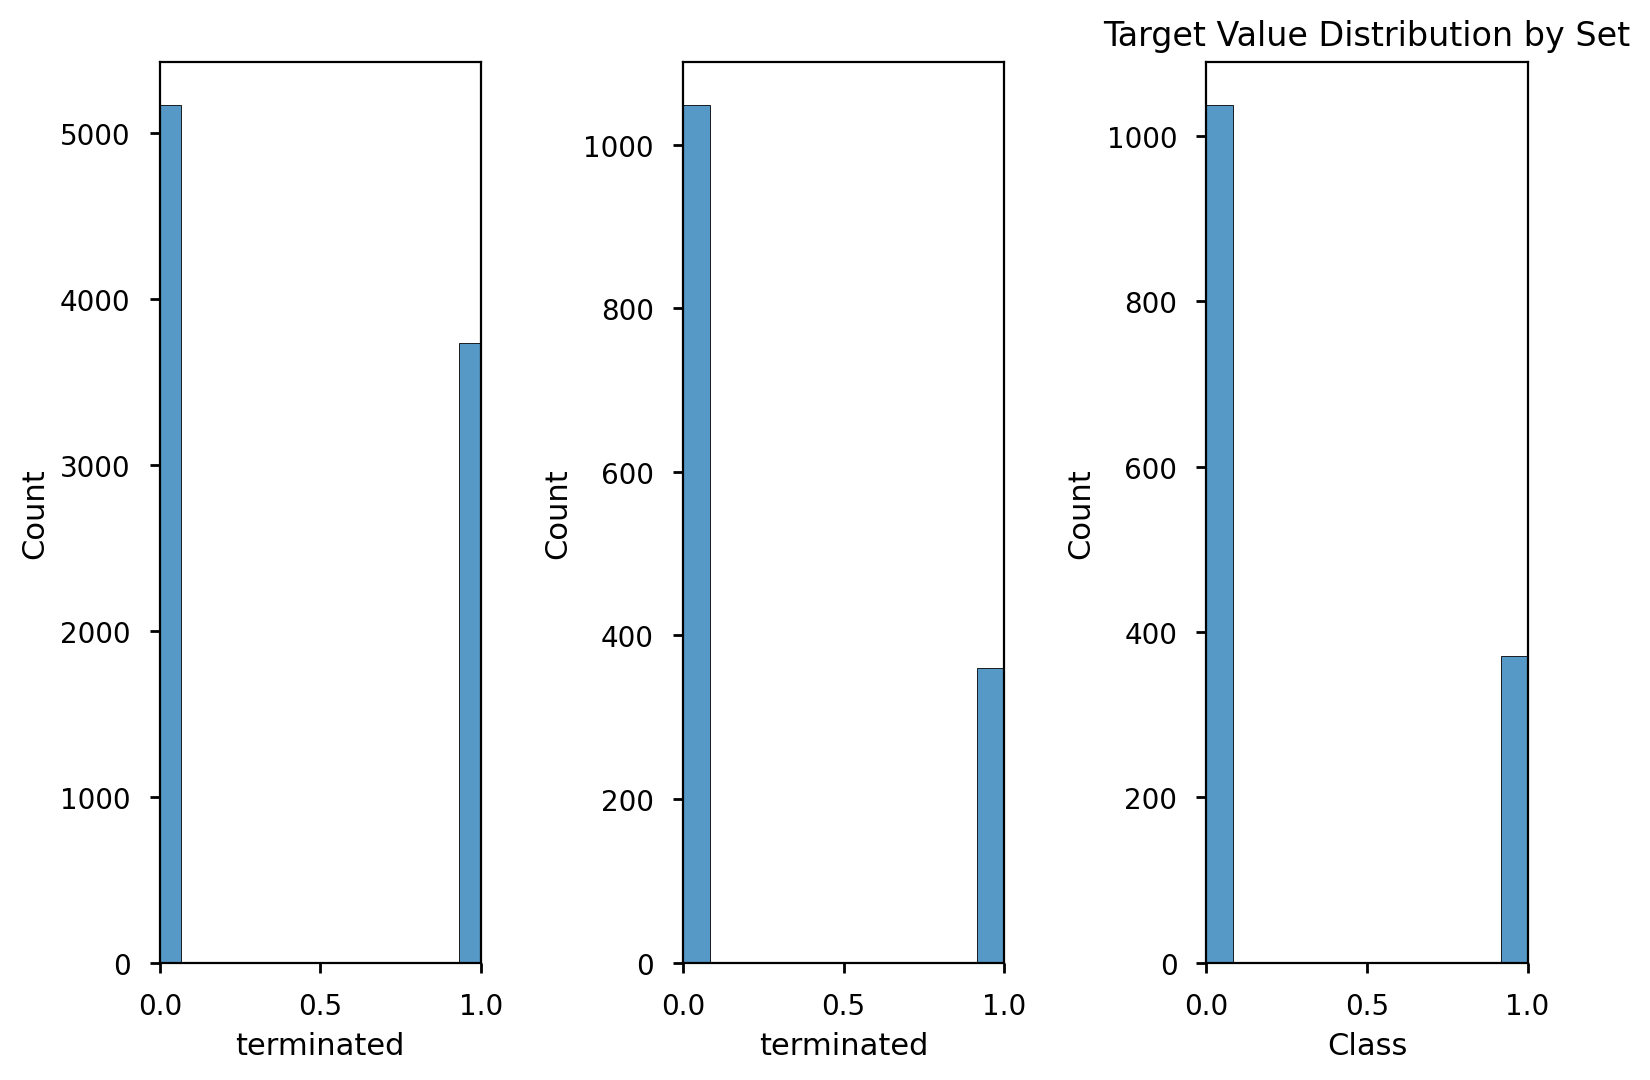

In [24]:
# visualizing train, valid, test target value distribution
figs, axes = plt.subplots(1,3,sharex=True)
sns.histplot(y_train,ax=axes[0])
sns.histplot(y_valid,ax=axes[1])
sns.histplot(y_test,ax=axes[2])
plt.title('Target Value Distribution by Set')
plt.xlim([0,1])
plt.xlabel('Class')
plt
plt.tight_layout()
plt.show()

In [25]:
# Scaling continuos features
numeric = ['monthly_charges','total_charges']
scaler = MaxAbsScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [26]:
X_train[numeric]

,monthly_charges,total_charges
2935,0.592421,0.474927
5898,0.643789,0.520392
3046,0.964211,0.521307
115,0.973053,0.935842
1980,0.751158,0.039863
...,...,...
6118,0.585263,0.207264
5609,0.643789,0.128679
4793,0.167158,0.145893
2986,0.461053,0.051337


---
## CATBOOST
---

In [27]:
# OneHotEncoding categorical features
cat_cols = [
    'type',
    'paperless_billing', 
    'payment_method',           
    'gender',                   
    'senior_citizen',             
    'partner',                    
    'dependents',             
    'internet_service',        
    'online_security',           
    'online_backup',            
    'device_protection',         
    'tech_support',              
    'streaming_tv',            
    'streaming_movies',       
    'multiple_lines',          
]

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [28]:

# creating dictionary for hyperparameter tuning
state = 12345
params = {
    'learning_rate' : [0.1,0.41,0.1],
    'n_estimators' : np.arange(200,400,25),
    'l2_leaf_reg' : np.arange(1,5,1)
}

# Setting Catboost model parameters
cat = CatBoostClassifier(
    iterations = 10000,
    cat_features = cat_cols,
    loss_function = 'CrossEntropy',
    verbose = 2,
    eval_metric = 'AUC',
    random_seed = state
)

In [29]:
pool = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_cols
)

In [30]:
# initializing grid search
cat_search = cat.grid_search(
    X = pool,
    param_grid = params,
    plot = True,
    stratified = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8286564	best: 0.8286564 (0)	total: 77.6ms	remaining: 15.4s
2:	test: 0.8414418	best: 0.8414418 (2)	total: 97.4ms	remaining: 6.39s
4:	test: 0.8487107	best: 0.8487107 (4)	total: 114ms	remaining: 4.44s
6:	test: 0.8532744	best: 0.8532744 (6)	total: 133ms	remaining: 3.66s
8:	test: 0.8547321	best: 0.8547321 (8)	total: 149ms	remaining: 3.17s
10:	test: 0.8551638	best: 0.8551638 (10)	total: 167ms	remaining: 2.87s
12:	test: 0.8567445	best: 0.8567445 (12)	total: 185ms	remaining: 2.67s
14:	test: 0.8580324	best: 0.8580324 (14)	total: 203ms	remaining: 2.5s
16:	test: 0.8587786	best: 0.8587786 (16)	total: 220ms	remaining: 2.37s
18:	test: 0.8590495	best: 0.8590495 (18)	total: 237ms	remaining: 2.26s
20:	test: 0.8599810	best: 0.8599810 (20)	total: 255ms	remaining: 2.17s
22:	test: 0.8615803	best: 0.8615803 (22)	total: 274ms	remaining: 2.11s
24:	test: 0.8621651	best: 0.8621651 (24)	total: 298ms	remaining: 2.08s
26:	test: 0.8629493	best: 0.8629493 (26)	total: 330ms	remaining: 2.12s
28:	test: 0.863

In [31]:
cat.get_params()

{'iterations': 375,
 'loss_function': 'CrossEntropy',
 'random_seed': 12345,
 'verbose': 2,
 'eval_metric': 'AUC',
 'cat_features': ['type',
  'paperless_billing',
  'payment_method',
  'gender',
  'senior_citizen',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines'],
 'learning_rate': 0.41,
 'l2_leaf_reg': 1}

In [32]:

cat_pred = cat.predict(X_valid)
cat_proba = cat.predict_proba(X_valid)[:,1]
tpr, fpr, thresholds = roc_curve(y_valid,cat_proba)

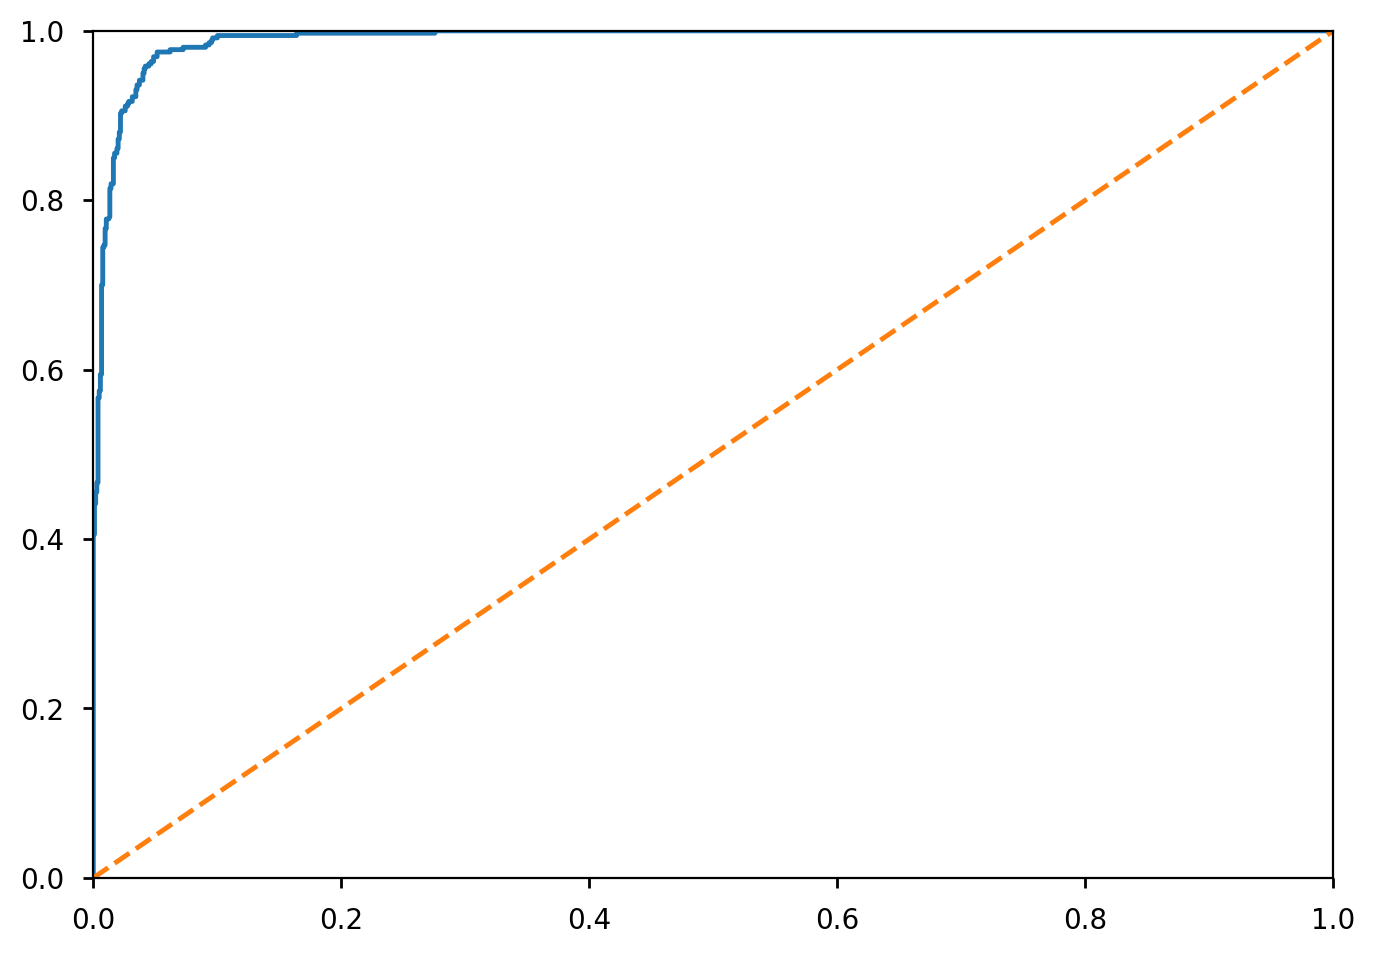

Accuracy score:  0.9446415897799858
F1 score:  0.9002557544757033
ROC-AUC score:  0.9902354093845991


In [33]:
# Plotting ROC-AUC curve
plt.figure()
plt.plot(tpr,fpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.show()
print('Accuracy score: ', accuracy_score(y_valid,cat_pred))
print('F1 score: ', f1_score(y_valid,cat_pred))
print('ROC-AUC score: ', roc_auc_score(y_valid,cat_proba))

---
## XGBOOST
---

In [34]:
# OneHotEncoding 
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

In [35]:
# splitting into training and test sets
# X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2,random_state=state)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state = state)

# print(X_train.shape,y_train.shape)
# print(X_valid.shape, y_valid.shape)
# print(X_test.shape,y_test.shape)

In [36]:
print(X_train.columns)

# Saving feature types for model hyperrparameter
feat_types = ['c','c','c','q','q','c','c','c','c','c','c','c','c','c','c','c','c','q']

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'service_length'],
      dtype='object')


In [37]:
# Mapping hyperparameters for hypertuning
params = {
    'n_estimators' : [150, 300],
    'eta' : np.arange(0.1,0.51,0.1),
    'grow_policy' : ['depthwise', 'lossguide']
}

In [38]:
x_boost = xgb.XGBClassifier(feature_types = feat_types, random_state=state)

In [39]:
x_grid = GridSearchCV(
    estimator = x_boost,
    param_grid = params,
    scoring = ['roc_auc','f1'],
    refit = 'f1',
    verbose = 4,
    n_jobs = 6,
    cv = 3
)

In [40]:
x_grid.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 3/3] END eta=0.1, grow_policy=depthwise, n_estimators=150; f1: (test=0.764) roc_auc: (test=0.880) total time=   0.4s
[CV 1/3] END eta=0.1, grow_policy=depthwise, n_estimators=150; f1: (test=0.761) roc_auc: (test=0.875) total time=   0.5s
[CV 2/3] END eta=0.1, grow_policy=depthwise, n_estimators=150; f1: (test=0.772) roc_auc: (test=0.880) total time=   0.5s
[CV 3/3] END eta=0.1, grow_policy=depthwise, n_estimators=300; f1: (test=0.792) roc_auc: (test=0.889) total time=   0.8s
[CV 2/3] END eta=0.1, grow_policy=depthwise, n_estimators=300; f1: (test=0.794) roc_auc: (test=0.891) total time=   0.8s
[CV 1/3] END eta=0.1, grow_policy=depthwise, n_estimators=300; f1: (test=0.774) roc_auc: (test=0.884) total time=   0.8s
[CV 1/3] END eta=0.1, grow_policy=lossguide, n_estimators=150; f1: (test=0.761) roc_auc: (test=0.875) total time=   0.5s
[CV 3/3] END eta=0.1, grow_policy=lossguide, n_estimators=150; f1: (test=0.764) roc_auc: (te

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=['c', 'c', 'c', 'q', 'q',
                                                    'c', 'c', 'c', 'c', 'c',
                                                    'c', 'c', 'c', 'c', 'c',
                                                    'c', 'c', 'q'],
                                     feature_weights=None, gamma=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=6,
             param_grid={'eta': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'grow_policy': ['depthwise', 'lossguide'],
                         'n_estimators': [150, 300]},
             refit='f1', scoring=['roc_auc', 'f1'], verbose=4)

In [41]:
x_grid.best_params_

{'eta': 0.30000000000000004, 'grow_policy': 'depthwise', 'n_estimators': 300}

In [42]:
x_pred = x_grid.predict(X_valid)
x_proba = x_grid.predict_proba(X_valid)[:,1]
tpr, fpr, thresholds = roc_curve(y_valid,x_proba)

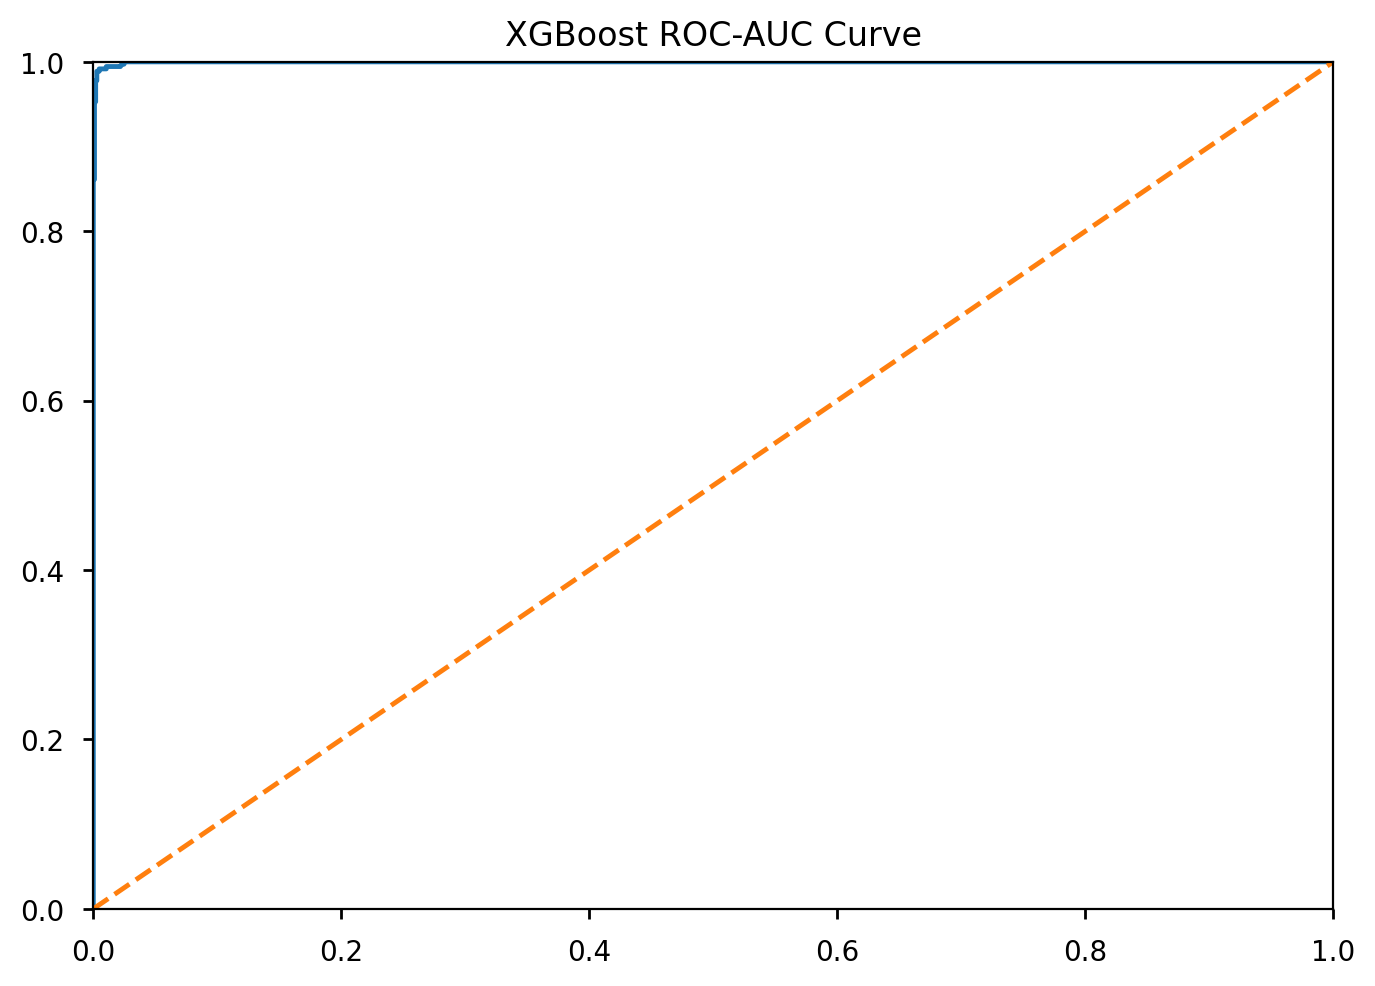

Accuracy score:  0.9879347054648687
F1 score:  0.9768076398362893
ROC-AUC score:  0.9996597288422837


In [43]:
# Plotting ROC-AUC curve
plt.figure()
plt.plot(tpr,fpr)
plt.plot([0,1],[0,1],linestyle=('--'))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.title('XGBoost ROC-AUC Curve')
plt.show()

# Generating scores for xgboost model
print('Accuracy score: ', accuracy_score(y_valid,x_pred))
print('F1 score: ', f1_score(y_valid, x_pred))
print('ROC-AUC score: ', roc_auc_score(y_valid, x_proba))

---
## KNeighbors
---

In [44]:
# Mapping hyperparameter values for hypertuning
params = {
    'n_neighbors' : np.arange(1,6,1),
    'leaf_size' : np.arange(10,51,10),
    'p' : [1,2],
    'weights' :['uniform', 'distance']
}

In [45]:
# Initializing KNeighbors model
kn = KNeighborsClassifier()

In [46]:
# Initializing grid search hypertuning wrapper
k_grid = GridSearchCV(
    estimator = kn,
    param_grid = params,
    verbose = 4,
    scoring = ['roc_auc','f1'],
    refit = 'f1',
    cv = 5
)

In [47]:
k_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END leaf_size=10, n_neighbors=1, p=1, weights=uniform; f1: (test=0.815) roc_auc: (test=0.839) total time=   0.5s
[CV 2/5] END leaf_size=10, n_neighbors=1, p=1, weights=uniform; f1: (test=0.825) roc_auc: (test=0.848) total time=   0.5s
[CV 3/5] END leaf_size=10, n_neighbors=1, p=1, weights=uniform; f1: (test=0.815) roc_auc: (test=0.839) total time=   0.4s
[CV 4/5] END leaf_size=10, n_neighbors=1, p=1, weights=uniform; f1: (test=0.822) roc_auc: (test=0.845) total time=   0.3s
[CV 5/5] END leaf_size=10, n_neighbors=1, p=1, weights=uniform; f1: (test=0.812) roc_auc: (test=0.836) total time=   0.3s
[CV 1/5] END leaf_size=10, n_neighbors=1, p=1, weights=distance; f1: (test=0.815) roc_auc: (test=0.839) total time=   0.2s
[CV 2/5] END leaf_size=10, n_neighbors=1, p=1, weights=distance; f1: (test=0.825) roc_auc: (test=0.848) total time=   0.2s
[CV 3/5] END leaf_size=10, n_neighbors=1, p=1, weights=distance; f1: (test=0.815)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([10, 20, 30, 40, 50]),
                         'n_neighbors': array([1, 2, 3, 4, 5]), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             refit='f1', scoring=['roc_auc', 'f1'], verbose=4)

In [48]:
k_grid.best_estimator_

KNeighborsClassifier(leaf_size=10, p=1, weights='distance')

In [49]:
k_pred = k_grid.predict(X_valid)
k_proba = k_grid.predict_proba(X_valid)[:,1]
tpr,fpr, thresholds = roc_curve(y_valid, k_proba)

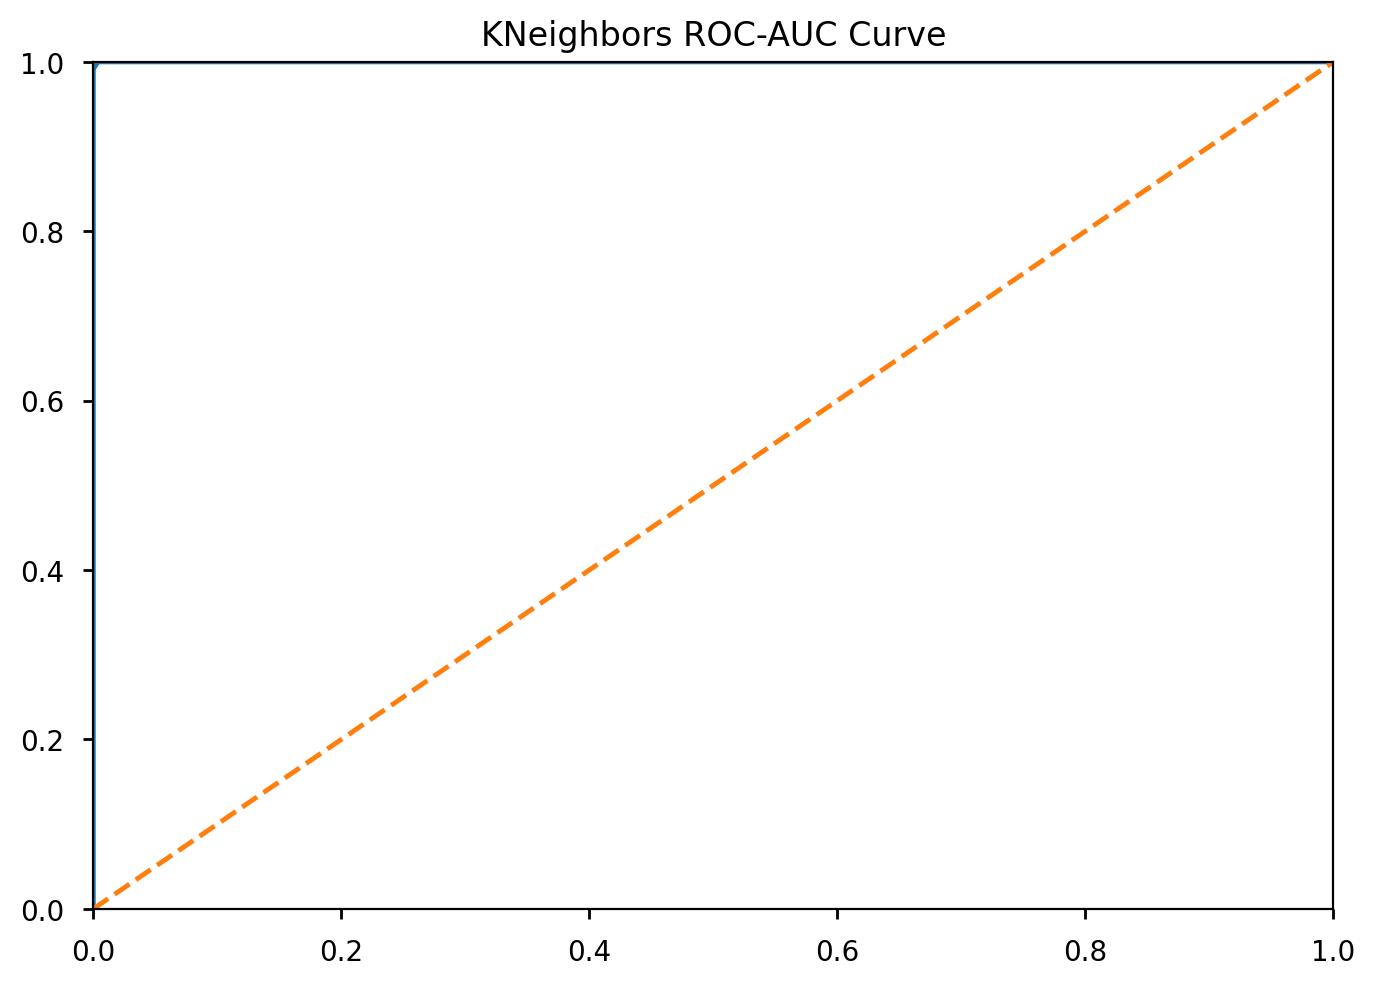

Accuracy score:  0.9971611071682044
F1 score:  0.994475138121547
ROC-AUC score:  0.999984111852558


In [50]:
# Plotting KNeighbors ROC-AUC curve
plt.figure()
plt.plot(tpr,fpr)
plt.plot([0,1],[0,1],linestyle=('--'))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.title('KNeighbors ROC-AUC Curve')
plt.show()

# Generating model scores
print('Accuracy score: ', accuracy_score(y_valid,k_pred))
print('F1 score: ', f1_score(y_valid, k_pred))
print('ROC-AUC score: ', roc_auc_score(y_valid, k_proba))

Amazing results using the KNeighbors model with the following hyperparameters: `leaf_size=10, p=1, weights='distance'`! It outperformed our nearly perfect XGBoostClassifier model. Being that the xgb and KNeighbors models were so close in score we'll measure the models' performance using confusion matrix to determine which model we'll choose for our final testing.

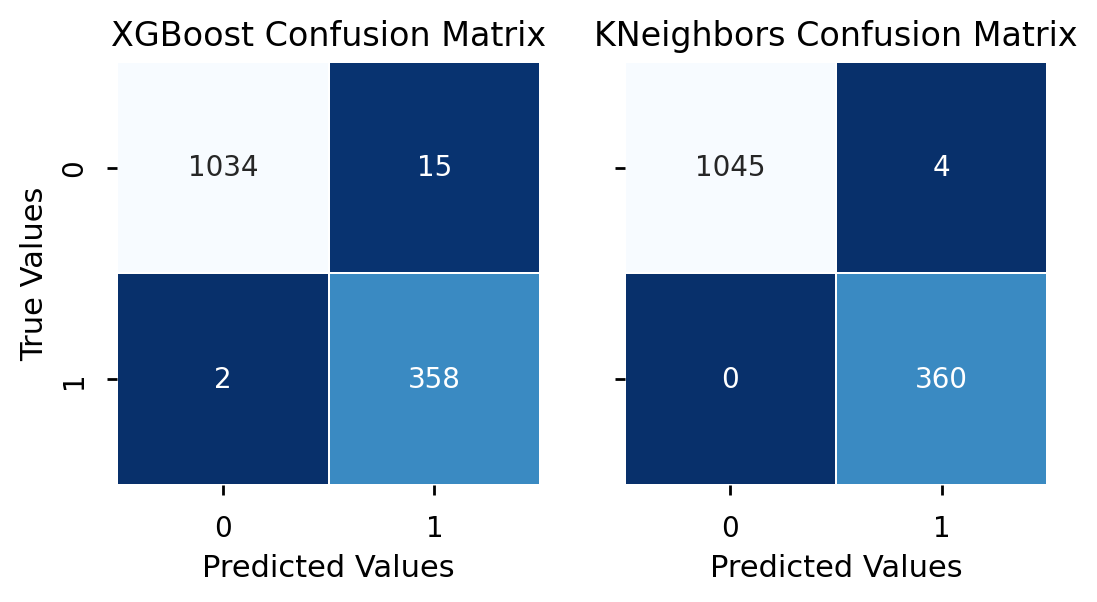

<Figure size 800x550 with 0 Axes>

In [51]:
# Subplotting both confusion matrixes for ease of comparison
conf_matrix_x = confusion_matrix(y_valid,x_pred)
conf_matrix_k = confusion_matrix(y_valid,k_pred)

figs, axes = plt.subplots(1,2,figsize=(6,6),sharey = True)

sns.heatmap(
    conf_matrix_x, annot=True, fmt='.0f',linewidth=.6,square=True,cmap='Blues_r',cbar=False,ax=axes[0])
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('True Values')
axes[0].set_title('XGBoost Confusion Matrix')

plt.figure()
sns.heatmap(
    conf_matrix_k, annot=True, fmt='.0f',linewidth=.6,square=True,cmap='Blues_r',cbar=False,ax=axes[1])
axes[1].set_title('KNeighbors Confusion Matrix')
axes[1].set_xlabel('Predicted Values')
plt.tight_layout()
plt.show()

The confusion matrix for our XGBoost model shows the model correctly predicted 1034 true negatives and 358 true positives with only 2 false negative. Not bad at all. The XGBoost model incorrectly predicted 15 false positives. This indicates 2 customers/accounts would have fell through the cracks with those false negative predictions. The results of the model proved it could have saved 99% of the churned customers. Pretty good success rate but could still lose some money if discounts or offers are sent to entice those 15 customers who were falsely predicted to leave.

Our KNeighbors model's confusion matrix looks a tad bit better. 1045 true negatives were predicted and a hair better than the XGBoost model with 360 True positives with 0 false negatives. Only 4 false positives were predicted for the validation set using the KNeighbors model. With these results, we have a winner!

We will choose to move forward with our kneighbors model for our final test.

---
## Final Testing
---

In [52]:
# Generating predictions
final_pred = k_grid.predict(X_test)
final_proba = k_grid.predict_proba(X_test)[:,1]
tpr, fpr, thresholds = roc_curve(y_test, final_proba)
final_conf = confusion_matrix(y_test, final_pred)

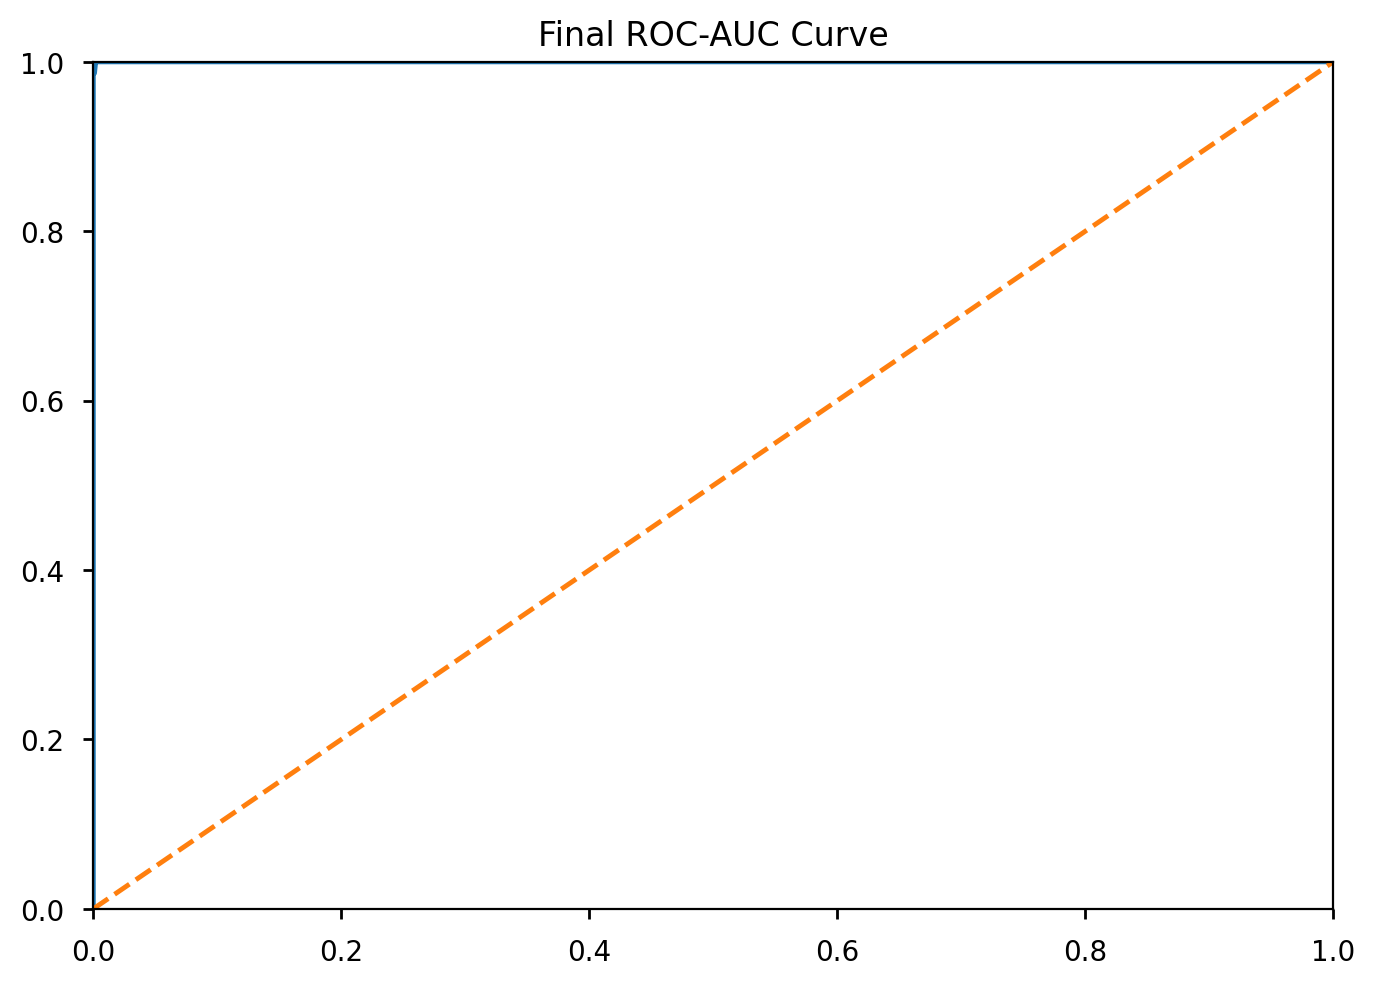

Final accuracy score:  0.9985805535841022
Final f1 score:  0.9973118279569892
Final ROC-AUC score:  0.9999805244379353


In [53]:
# Plotting ROC-AUC curve
plt.figure()
plt.plot(tpr,fpr)
plt.plot([0,1],[0,1],linestyle=('--'))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.title('Final ROC-AUC Curve')
plt.show()

# Getting model final test scores
print('Final accuracy score: ', accuracy_score(y_test, final_pred))
print('Final f1 score: ', f1_score(y_test,final_pred))
print('Final ROC-AUC score: ', roc_auc_score(y_test, final_proba))

Another set of nearly perfect scores. These results far exceed our model's roc_auc score threshold. The ROC-AUC curve can barely been seen its so close to the y-axis. Can only see a spec of area over the curve on the top right corner.

Let's get a better view of model's final test performance using a confusiong= matrix.

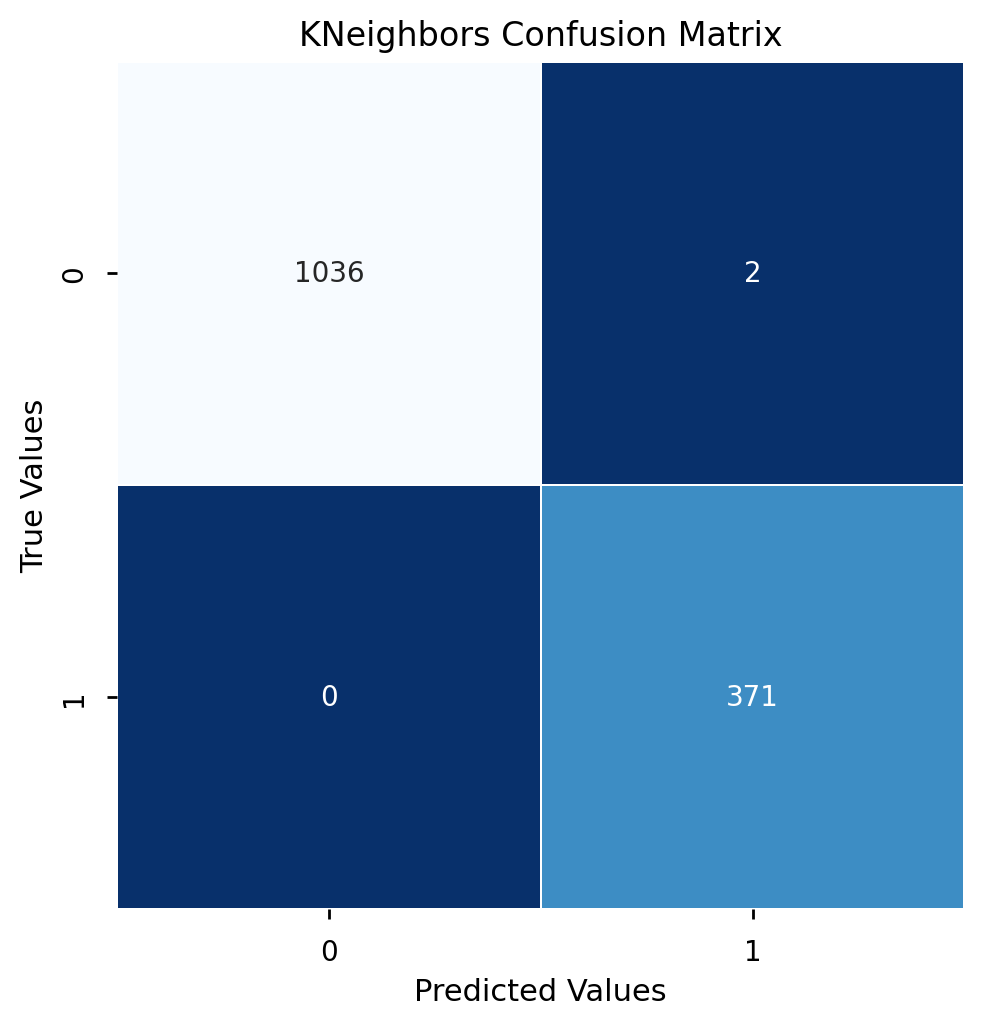

In [54]:
# Plotting confusion matrix for final test results
sns.heatmap(
    final_conf, annot=True, fmt='.0f',linewidth=.6,square=True,cmap='Blues_r',cbar=False)
plt.title('KNeighbors Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()


Can't really get mcuh better than these results. Our model correctly predicted all 371 churned customers and was only incorrect on 2 false positives. Our model only made 2 total errors out of 1409 predictions. Not bad at all.

We'll move on to our solutions report.

---
# Conclusion
---
In conclusion, our work plan led us to a fully functional model that minimizes customer churn almost completely. We tried a few different approaches, and found that the kneighbors algorithm fit best in solving the company's churn problem. Using our final model we can feel confident will efficiently identify potential customers at risk of churning. This can give the company an opportunity to intervene and send promotions to potentially retain customers at risk of terminating their services.